## Exercise 4 – identifying vulnerability-contributing commits

### Initialise modules

In [108]:
! pip3 install GitPython
! pip3 install seaborn
! pip3 install pydriller

import numpy as np
import pandas as pd
import os
import time

import git
from git import RemoteProgress
from git import Repo

import matplotlib.pyplot as plt
import seaborn as sns

BLUE   = '\033[94m'
GREEN  = '\033[92m'
ORANGE = '\033[93m'
RED    = '\033[91m'
ENDC   = '\033[0m'

### Clone github repositories

In [109]:
url_a = "https://github.com/opennetworkinglab/onos"
dir_a = "onos"

url_b = "https://github.com/apache/ofbiz/"
dir_b = "ofbiz"

url_c = "https://github.com/apache/struts/"
dir_c = "struts"

if not os.path.isdir(dir_a):
    Repo.clone_from(url_a, dir_a)
if not os.path.isdir(dir_b):
    Repo.clone_from(url_b, dir_b)
if not os.path.isdir(dir_c):
    Repo.clone_from(url_c, dir_c)

### Set repository ('local_link') and fixing commit ('fixing_commit')

In [255]:
##### (1) ONOS
local_link = "onos"
fixing_commit = "af1fa39a53c0016e92c1de246807879c16f507d6"

##### (2) OFBIZ
# local_link = "ofbiz"
# fixing_commit = "34125e42d1db74064482c296c871e11c92dc4527"   # Not commit listed in spreadsheet 

##### (3) STRUTS
# local_link = "struts"
# fixing_commit = "9d47af6ffa355977b5acc713e6d1f25fac260a28"

##### (4) CAMEL
# local_link = "camel"
# fixing_commit = "6b979d07fd4be6ac913368f2abeae690d3325d37"

##### (5) GEODE
# local_link = "geode"
# fixing_commit = "954ccb545d24a9c9a35cbd84023a4d7e07032de0"

##### (6) JETTY
# local_link = "jetty.project"
# fixing_commit = "3e7b5f0fa918633ec24bd1bc23d6ee76d32c7729"


repo = Repo(local_link)

### Print summary info for fixing commit (to confirm it exists)

In [256]:
for commit in list(repo.iter_commits()):
    # must include '.hexsha' or '==' won't match them even if console output looks the same
    if commit.hexsha == fixing_commit:
        affected_files = commit.stats.files
        print(commit.stats.files)

{'cli/src/main/java/org/onosproject/cli/net/DeviceSetControllersCommand.java': {'insertions': 29, 'deletions': 9, 'lines': 38}, 'drivers/utilities/src/main/java/org/onosproject/drivers/utilities/XmlConfigParser.java': {'insertions': 35, 'deletions': 11, 'lines': 46}}


### Print the file, highlighting lines added (blue) or deleted (orange)

In [257]:
import io
import sys

# printing the 'difference': so just the lines added or deleted
# is not enough: need the whole file + the lines added/deleted

# 1. store the lines added and deleted
# 2. loop through the full file, highlight the lines added or deleted
# 3. 'expand' added lines to the full scope

# (1) if line has no indentation, it is of global scope and it will be treated as a single line
# (2) if not global scope, 'keep looking upwards till it encounters a starting bracket'
# (3)  if not global scope'keep looking downwards till it encounters a closing bracket'

full_lines = []
add_lines  = []
sub_lines  = []
blame_lines= []

diff_data = repo.git.diff(fixing_commit + "^", fixing_commit).splitlines()

commit = repo.commit(fixing_commit)

for line in diff_data:

    # ignore 'file path' lines
    if line.startswith("++") or line.startswith("--"):
        continue

    if line.startswith("+"):
        add_lines.append(line)
    if line.startswith("-"):
        sub_lines.append(line)  

for affected_file in affected_files:
    print("############################## File: " + affected_file + " ##################################")
    searchScope = False
    
    # retrieve the full contents of the modified file
    targetfile = commit.tree / affected_file
    with io.BytesIO(targetfile.data_stream.read()) as f:
        full_lines = f.read().decode('utf-8').splitlines()

    print("addlines[0] = ", add_lines[0])

    for full_line in full_lines:
        if len(add_lines) == 0:
            break
            
        # if the line has no leading whitespace, it is of global scope and is treated individually
        if len(full_line.lstrip()) == len(full_line):
            searchScope = False
       
        elif full_line.strip().endswith("}"):
            searchScope = False            
            
        # to prevent duplicates, always take the first item, then remove it
        if add_lines[0][1:] == full_line:
            searchScope = True
            print("[" + BLUE, full_line, ENDC + "]")
            # do NOT add 'added' lines to the blame list: these have been added by
            # the fixing commit, and so will just be 'blamed' on the vulnerability fixer
            # blame_lines.append(full_line)
            add_lines.pop(0)  
        else:
            if searchScope == True:
                print("[" + ORANGE + full_line + ENDC + "]")
                blame_lines.append(full_line)
            else:
                print("[" + full_line + "]")
       

print("should be empty: ", add_lines) 

# jetty (#6)
# blame_lines = ["        private IllegalCharacterException(State state,byte ch,ByteBuffer buffer)"]
 

############################## File: cli/src/main/java/org/onosproject/cli/net/DeviceSetControllersCommand.java ##################################
addlines[0] =  +        if (controllersListStrings == null && !removeCont && !removeAll) {
[/*]
[ * Copyright 2015-present Open Networking Foundation]
[ *]
[ * Licensed under the Apache License, Version 2.0 (the "License");]
[ * you may not use this file except in compliance with the License.]
[ * You may obtain a copy of the License at]
[ *]
[ *     http://www.apache.org/licenses/LICENSE-2.0]
[ *]
[ * Unless required by applicable law or agreed to in writing, software]
[ * distributed under the License is distributed on an "AS IS" BASIS,]
[ * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.]
[ * See the License for the specific language governing permissions and]
[ * limitations under the License.]
[ */]
[]
[package org.onosproject.cli.net;]
[]
[import org.apache.karaf.shell.commands.Argument;]
[import org.apache.kar

### Assign blame to lines identified in 'vulnerable scope' (from lines *added*)

In [258]:
# git blame = "Annotates each line in the given file with information from the revision which last modified the line"
    
blame_commits = []
blame_commits_unique = []

# loop through the array of files affected by the fixing commit
for affected_file in affected_files:
    print("############################## New file ##################################")

    print("blamelines[0] = ", blame_lines[0])

    for commit, lines in repo.blame(fixing_commit, affected_file):
        for line in lines:
            
            if len(blame_lines) == 0:
                break
                
            if blame_lines[0] == line:
                blame_lines.pop(0)  
                print("[" + BLUE + line + ENDC + "] commit [" + GREEN, commit, ENDC + "]")
                blame_commits.append(commit)
                if commit not in blame_commits_unique:
                    blame_commits_unique.append(commit)
            else:
                print("[" + line + "]")


        print("")
    

############################## New file ##################################
blamelines[0] =          DriverService service = get(DriverService.class);
[/*]

[ * Copyright 2015-present Open Networking Foundation]

[ *]
[ * Licensed under the Apache License, Version 2.0 (the "License");]
[ * you may not use this file except in compliance with the License.]
[ * You may obtain a copy of the License at]
[ *]
[ *     http://www.apache.org/licenses/LICENSE-2.0]
[ *]
[ * Unless required by applicable law or agreed to in writing, software]
[ * distributed under the License is distributed on an "AS IS" BASIS,]
[ * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.]
[ * See the License for the specific language governing permissions and]
[ * limitations under the License.]
[ */]
[]
[package org.onosproject.cli.net;]
[]
[import org.apache.karaf.shell.commands.Argument;]
[import org.apache.karaf.shell.commands.Command;]

[import org.apache.karaf.shell.commands.Option;]

[import

### Add commits from lines *subtracted* to the blame list

In [259]:
print(sub_lines)

print("[" + sub_lines[0][1:] + "]")

for affected_file in affected_files:
    for commit, lines in repo.blame(fixing_commit, affected_file):
        for line in lines:  
            print("[" + line + "]")
            if line.strip() == sub_lines[0][1:].strip():
                
                print("%s changed this line: %s" % (commit, line))
                blame_commits.append(commit)
                if commit not in blame_commits_unique:
                    blame_commits_unique.append(commit)
                
                sub_lines.pop(0)

['-        Arrays.asList(controllersListStrings).forEach(', '-                cInfoString -> controllers.add(parseCInfoString(cInfoString)));', '-            String[] data = config[0].split(":");', '-            String type = data[0];', '-            IpAddress ip = IpAddress.valueOf(data[1]);', '-            int port = Integer.parseInt(data[2]);', '-        } else {', '-            print(config[0]);', '-            return new ControllerInfo(config[0]);', '-        XMLConfiguration cfg = new XMLConfiguration();', '-        } catch (ConfigurationException e) {', '-                                             "logical-switches." +', '-                                             "switch.controllers.controller");', '-                                            "logical-switches." +', '-                                            "switch");', '-                        parseCapableSwitchId(actualCfg));', '-                                "logical-switches.switch.id", parseSwitchId(actualCfg)

### Calculate the VCC

In [260]:
print("List of commits that contributed to the vulnerable code portions:\n")
worst_commit = None
worst_number = 0
for unique_commit in blame_commits_unique:
    if blame_commits.count(unique_commit) > worst_number:
        worst_commit = unique_commit
        worst_number = blame_commits.count(unique_commit)
    print(GREEN, unique_commit, ENDC, " : ", BLUE, blame_commits.count(unique_commit), ENDC)

print("\nworst commit (VCC): ", RED, worst_commit, ENDC)

List of commits that contributed to the vulnerable code portions:

 ed976a405fa3db38903ce369c9ece7023d310a21   :   6 
 eb70a94b5504180de5772d5229a4aae353960240   :   30 
 67de597c5d2ccef246c7f564beab6064695e509c   :   7 
 54f28e23ac9a969f7d33d5756c9f929bf97c6520   :   1 
 676249ca1a4724f06b4781aedee490dbbbcfc20f   :   1 
 1dff77cd0f13bd635ca43f5ede5d66e725de23d9   :   7 
 af1fa39a53c0016e92c1de246807879c16f507d6   :   1 

worst commit (VCC):   eb70a94b5504180de5772d5229a4aae353960240 


### Is the VCC the initial commit?

In [261]:
!cd $local_link; git log --pretty=oneline --reverse | head -1

cda04cffc94bc0b80ddb85ec68ad790a5088fbc4 Initial empty repository


### (a) Message and title of VCC commit

In [262]:
show_data = repo.git.show("-s", worst_commit).splitlines()
for line in show_data:
    print(line)

commit eb70a94b5504180de5772d5229a4aae353960240
Author: andrea <andrea@onlab.us>
Date:   Fri Oct 16 21:34:46 2015 -0700

    [ONOS-3253/3144] Insert support for Netconf device configuration, set and get controllers commands
    
    Change-Id: I99188aa18207b9d0b0d935b9f9e61e547f4ddab1


### (b) total files affected 

In [263]:
# 'commit.hexsha' can be replaced with just 'commit'
print("total repo commits: ", len(list(repo.iter_commits())), "\n")

for commit in list(repo.iter_commits()):
#     print(commit)
#     print(commit.message)
    if commit.hexsha == worst_commit.hexsha: 
        print(commit.stats.files)
        print("\nnumber of files affected: ", len(commit.stats.files), "\n")
        print("commit hash: ", commit)

total repo commits:  14502 

{'cli/src/main/java/org/onosproject/cli/net/DeviceSetControllersCommand.java': {'insertions': 5, 'deletions': 2, 'lines': 7}, 'drivers/features.xml': {'insertions': 2, 'deletions': 0, 'lines': 2}, 'drivers/pom.xml': {'insertions': 5, 'deletions': 0, 'lines': 5}, 'drivers/src/main/java/org/onosproject/driver/netconf/NetconfControllerConfig.java': {'insertions': 89, 'deletions': 0, 'lines': 89}, 'drivers/src/main/java/org/onosproject/driver/netconf/XmlConfigParser.java': {'insertions': 126, 'deletions': 0, 'lines': 126}, 'drivers/src/main/java/org/onosproject/driver/netconf/package-info.java': {'insertions': 20, 'deletions': 0, 'lines': 20}, 'drivers/src/main/resources/onos-drivers.xml': {'insertions': 7, 'deletions': 0, 'lines': 7}, 'drivers/src/main/resources/org/onosproject/driver/netconf/controllers.xml': {'insertions': 36, 'deletions': 0, 'lines': 36}, 'drivers/src/test/java/org/onosproject/driver/netconf/XmlConfigParserTest.java': {'insertions': 80, 'de

### (c) total directories affected 

In [264]:
dirs = []

for commit in list(repo.iter_commits()):
    if str(commit) == worst_commit.hexsha: 
        
        for file in commit.stats.files:
#             print(file)
            folder = file.split("/")[0:-1]
            folderpath =  "/".join(folder)
            print("folder: " + folderpath)
            if folderpath not in dirs:
                dirs.append(folderpath)

print("\nTotal unique directories: ", len(dirs))

folder: cli/src/main/java/org/onosproject/cli/net
folder: drivers
folder: drivers
folder: drivers/src/main/java/org/onosproject/driver/netconf
folder: drivers/src/main/java/org/onosproject/driver/netconf
folder: drivers/src/main/java/org/onosproject/driver/netconf
folder: drivers/src/main/resources
folder: drivers/src/main/resources/org/onosproject/driver/netconf
folder: drivers/src/test/java/org/onosproject/driver/netconf
folder: drivers/src/test/resources/org/onosproject/driver/netconf
folder: netconf/api
folder: netconf/api/src/main/java/org/onosproject/netconf
folder: netconf/api/src/main/java/org/onosproject/netconf
folder: netconf/api/src/main/java/org/onosproject/netconf
folder: netconf/api/src/main/java/org/onosproject/netconf
folder: netconf/api/src/main/java/org/onosproject/netconf
folder: netconf/api/src/main/java/org/onosproject/netconf
folder: netconf/ctl
folder: netconf/ctl/src/main/java/org/onosproject/netconf/ctl
folder: netconf/ctl/src/main/java/org/onosproject/netconf

### (d) total lines of code (INCLUDING comments and blank lines) deleted
### (e) total lines of code (INCLUDING comments and blank lines) added
### (f) total lines of code (EXCLUDING comments and blank lines) deleted
### (g) total lines of code (EXCLUDING comments and blank lines) added

In [265]:
diff_data = repo.git.diff(worst_commit.hexsha + "^", worst_commit).splitlines()

total_lines_added_including_blank_comments   = 0
total_lines_added_excluding_blank_comments   = 0
total_lines_removed_including_blank_comments = 0
total_lines_removed_excluding_blank_comments = 0

isComment = False

for line in diff_data:

    # determine whether the line is an addition or a deletion
    isAdded   = False
    isRemoved = False
    
    if line.startswith("+"):
        isAdded = True 
    if line.startswith("-"):
        isRemoved = True

    # remove the leading '+'
    line = line[1:]

    # ignore 'file path' lines
    if line.startswith("++") or line.startswith("--"):
        continue
    
    # detect when comment code starts
    if line.strip().startswith("/*") or line.startswith('"""'):
        isComment = True

    # if line is empty or is a single-line comment, it is a 'blank or comment' line
    if len(line.strip()) == 0:
        total_lines_added_including_blank_comments += 1
#         print("[" + ORANGE + "BLANK" + ENDC + "]")
    elif isAdded and (isComment or line.startswith("//") or line.startswith("#")):
        total_lines_added_including_blank_comments += 1
#         print("[" + ORANGE + line + ENDC + "]")
    elif isAdded:
#             print("Whitespace chars: ", len(line), " vs total chars: ", len(line))
        total_lines_added_including_blank_comments += 1
        total_lines_added_excluding_blank_comments += 1
#         print("[" + BLUE + line + ENDC + "]")
    elif isRemoved:
#         print("[" + RED + line + ENDC + "]")
        total_lines_removed_including_blank_comments += 1
        total_lines_removed_excluding_blank_comments += 1      
       
        # detect when comment code ends
    if line.strip().endswith("*/") or line.endswith('"""'):
        isComment = False
        
print("total lines added (INCLUDING comments and blanks): ", total_lines_added_including_blank_comments)
print("total lines added (EXCLUDING comments and blanks): ", total_lines_added_excluding_blank_comments)
print("total lines removed (INCLUDING comments and blanks): ", total_lines_removed_including_blank_comments)
print("total lines removed (EXCLUDING comments and blanks): ", total_lines_removed_excluding_blank_comments)

total lines added (INCLUDING comments and blanks):  1965
total lines added (EXCLUDING comments and blanks):  1178
total lines removed (INCLUDING comments and blanks):  1052
total lines removed (EXCLUDING comments and blanks):  1052


### (h) How many days between fixing commit and previous commit to the same file?
### (i) How many times has the file been modified since creation?
### (j) Which developers have modifed the file?

#### Blue = fixing commit
#### Green = previous commit (to VCC)
#### Orange = VCC

In [266]:
import math

last_commit_time = -1
between_time = -1
prevCommit = False
contributors = []
worst_commit_date = ""
fixing_commit_date = ""

print("worst_commit: ", worst_commit, "\n")

for affected_file in affected_files:
    print("\t", ORANGE, affected_file, ENDC)
    commits_touching_path = list(repo.iter_commits(paths=affected_file))

#     print(commits_touching_path)

    for commit in commits_touching_path:

        # GitPython differentiates between 'author' and 'commiter'
        # commited_date is in epoch time
        year  = str(time.localtime(commit.committed_date).tm_year)
        month = str(time.localtime(commit.committed_date).tm_mon)
        day   = str(time.localtime(commit.committed_date).tm_mday)

        if prevCommit:
            print(GREEN + commit.hexsha + ENDC + "\t" + day + "/" + month + "/" + year + "\t" + str(commit.committer))
            prevCommit = False
            between_time = last_commit_time - commit.committed_date
        elif commit.hexsha == worst_commit.hexsha:
            print(ORANGE + commit.hexsha + ENDC + "\t" + day + "/" + month + "/" + year + "\t" + str(commit.committer))
            last_commit_time = commit.committed_date
            worst_commit_date = commit.committed_date
            
            prevCommit = True
        elif commit.hexsha == fixing_commit:
            fixing_commit_date = commit.committed_date
            print(BLUE + commit.hexsha + ENDC + "\t" + day + "/" + month + "/" + year + "\t" + str(commit.committer))
        else:
            print(commit.hexsha + "\t" + day + "/" + month + "/" + year + "\t" + str(commit.committer))

        # add the contributor to the list of contributors, if they are not already on the list
        if str(commit.committer) not in contributors:
            contributors.append(str(commit.committer))

    print("\nTotal commits to file:", len(commits_touching_path))
    print("Days between worst commit and previous commit:", math.ceil(between_time / 86400), "days")
    print("Unique contributors: ", GREEN, contributors, ENDC)
    print("Total unique contributors to file: ", len(contributors), "\n\n")

worst_commit:  eb70a94b5504180de5772d5229a4aae353960240 

	  cli/src/main/java/org/onosproject/cli/net/DeviceSetControllersCommand.java 
0068fd084e2ce1bddf113c36cb63347ce4350c59	12/10/2018	Ray Milkey
d84f89ba3d18fb8e9c44fa0bab004d24c56b0a81	29/9/2018	Ray Milkey
af1fa39a53c0016e92c1de246807879c16f507d6	26/6/2018	Andrea Campanella
67de597c5d2ccef246c7f564beab6064695e509c	26/3/2018	Yuta HIGUCHI
a09fe5b0b75659dc9ff23fe938dd50aea0a0b129	4/8/2017	Brian O'Connor
54f28e23ac9a969f7d33d5756c9f929bf97c6520	3/8/2016	Gerrit Code Review
5ab426f9ffd145916bb41df408d7fef1781b9128	9/4/2016	Brian O'Connor
eb70a94b5504180de5772d5229a4aae353960240	20/11/2015	Gerrit Code Review
ed976a405fa3db38903ce369c9ece7023d310a21	9/10/2015	Gerrit Code Review

Total commits to file: 9
Days between worst commit and previous commit: 42 days
Unique contributors:   ['Ray Milkey', 'Andrea Campanella', 'Yuta HIGUCHI', "Brian O'Connor", 'Gerrit Code Review'] 
Total unique contributors to file:  5 


	  drivers/utilities/src/ma

### (k) for each developer identified, how many commits hav### (k) For each developer in (j), how may commits have they submitted? Are they experienced or new?e they made? Are they experienced?

In [267]:
commit_authors = repo.git.shortlog("-sne", "--all").splitlines()

author_commits = []

for commit_author in commit_authors:
    commit, author = commit_author.split("\t")
    # remove author's email
    author_clean = author.split("<")[0].strip()
#     print("author: [" + author_clean + "]")
    if author_clean in contributors:
        print("author: [" + author_clean + "]")
        author_commits.append([int(commit), author])
    
df = pd.DataFrame(author_commits, columns=['Commit', 'Author'])
df.head(100)

author: [Ray Milkey]
author: [Yuta HIGUCHI]
author: [Ray Milkey]
author: [Brian O'Connor]
author: [Yuta HIGUCHI]
author: [Andrea Campanella]
author: [HIGUCHI Yuta]
author: [Andrea Campanella]
author: [Brian O'Connor]
author: [Andrea Campanella]
author: [Yuta HIGUCHI]


,Commit,Author
0,873,Ray Milkey <ray@opennetworking.org>
1,667,Yuta HIGUCHI <y-higuchi@ak.jp.nec.com>
2,643,Ray Milkey <ray@onlab.us>
3,600,Brian O'Connor <bocon@onlab.us>
4,414,Yuta HIGUCHI <y-higuchi@onlab.us>
5,270,Andrea Campanella <andrea@opennetworking.org>
6,193,HIGUCHI Yuta <y-higuchi@ak.jp.nec.com>
7,133,Andrea Campanella <andrea@onlab.us>
8,22,Brian O'Connor <bocon@opennetworking.org>
9,4,Andrea Campanella <andrea@opennetwokring.org>


### Commit frequency between fixing and worst commit

local link:  onos
VSS commit date:     1447977785
fixing commit date:  1530006409
total commits:  14502
1569613300
1569538920
1569442389
1569374258
1569338680
1569338671
1569322063
1569264309
1569250864
1569235687
1568941987
1568799969
1568677842
1568659080
1568647341
1568622357
1568560147
1568559918
1568559847
1568198896
1567965713
1567348249
1567188721
1567180779
1567178797
1567130382
1567130382
1567130382
1567130382
1567126725
1567124903
1567105303
1567099669
1567063738
1567063731
1567063727
1567062864
1567062854
1567062838
1567062632
1567056489
1567033046
1567016680
1566910346
1566840769
1566590639
1566514073
1566484161
1566438516
1566345927
1566345691
1566333067
1565711324
1565642806
1565637345
1565637339
1565374746
1565374667
1565353676
1565340933
1565170497
1564748774
1564671787
1564653805
1564431456
1564424075
1564424070
1564396528
1564155574
1564130131
1564126744
1564059959
1564039741
1563906069
1563841357
1563839959
1563800913
1563797098
1563797034
1563521625
1563520964
15635

1544568486
1544568486
1544568486
1544567400
1544553685
1544518357
1544500082
1544462620
1544462608
1544461349
1544461133
1544438587
1544217607
1544217187
1544132240
1544129617
1544061276
1544055915
1544029681
1543964449
1543959324
1543946176
1543873860
1543814023
1543564281
1543536103
1543527269
1543517115
1543517110
1543467571
1543438939
1543431710
1543430948
1543430898
1543426688
1543407468
1543407030
1543394124
1543394107
1543394090
1543357742
1543352263
1543351047
1543351026
1543347930
1543340176
1543307057
1543307040
1543286083
1543286075
1543279442
1543277699
1543274153
1543266349
1543253066
1543224893
1542956244
1542952078
1542952070
1542846955
1542837076
1542831636
1542825140
1542825129
1542824274
1542824260
1542767928
1542748385
1542708590
1542694190
1542664273
1542664226
1542659203
1542646335
1542646319
1542624863
1542613302
1542595542
1542546323
1542341233
1542333691
1542323771
1542319477
1542311081
1542289640
1542267162
1542239706
1542234085
1542222552
1542221220
1542212050

1532570735
1532555727
1532555542
1532555542
1532555542
1532555542
1532555542
1532555542
1532552657
1532551445
1532545790
1532545299
1532540543
1532537737
1532537014
1532529872
1532511138
1532491805
1532462388
1532458426
1532454966
1532454057
1532452291
1532452259
1532452125
1532452088
1532452061
1532435483
1532434897
1532420009
1532375496
1532345743
1532342086
1532338171
1532322759
1532319258
1532319228
1532319221
1532317766
1532317761
1532317747
1532317613
1532315762
1532311646
1532229942
1532182456
1532110577
1532104405
1532103194
1532050759
1532042171
1532037369
1532036853
1532024992
1532017867
1532017745
1531971879
1531933252
1531862921
1531862059
1531854600
1531844251
1531844092
1531835302
1531835284
1531830210
1531830203
1531830193
1531830185
1531830176
1531782675
1531782663
1531773092
1531759523
1531759523
1531704190
1531703066
1531509749
1531507861
1531506737
1531504850
1531422571
1531417595
1531410430
1531376477
1531330891
1531326913
1531321302
1531308537
1531266308
1531264644

1522882177
1522878717
1522873251
1522872601
1522872464
1522872128
1522868466
1522866631
1522866631
1522866630
1522866629
1522861086
1522859572
1522849197
1522846284
1522802108
1522800974
1522800974
1522800974
1522800142
1522779699
1522776604
1522774143
1522773093
1522768701
1522729242
1522721552
1522707811
1522702015
1522701479
1522692929
1522631341
1522631334
1522456257
1522454450
1522440017
1522395093
1522388207
1522386295
1522341751
1522340695
1522284404
1522270508
1522256158
1522200350
1522199924
1522198468
1522103892
1522102624
1522097718
1522096216
1522095204
1522095197
1522089249
1522086926
1522039239
1522031477
1521838661
1521835228
1521820772
1521754938
1521754935
1521754827
1521751730
1521671948
1521666082
1521660124
1521621083
1521568501
1521534640
1521512934
1521501576
1521498110
1521479545
1521477448
1521477362
1521232205
1521212948
1521169372
1521135133
1521096562
1521076399
1521046513
1521045739
1521041577
1521036897
1520988956
1520982106
1520969875
1520967649
1520963017

1510788704
1510788689
1510786914
1510786375
1510786329
1510785744
1510785644
1510781941
1510772835
1510768433
1510754788
1510752454
1510699099
1510698821
1510691334
1510688619
1510688236
1510688160
1510687633
1510687587
1510686123
1510686039
1510648543
1510627757
1510626988
1510622541
1510620714
1510619475
1510618517
1510458088
1510365106
1510359928
1510359779
1510359683
1510354822
1510346044
1510345199
1510345109
1510344314
1510343700
1510342336
1510342234
1510342086
1510340317
1510335188
1510327167
1510301993
1510285501
1510263322
1510188148
1510068736
1510035095
1510019136
1510015001
1510006965
1510003841
1510001717
1509995688
1509995642
1509992579
1509985203
1509931820
1509931813
1509774817
1509773589
1509759021
1509758863
1509758274
1509753835
1509750809
1509749234
1509746407
1509744369
1509739518
1509732778
1509660236
1509658205
1509657764
1509657571
1509657473
1509653300
1509641561
1509641492
1509641467
1509583785
1509579783
1509579739
1509579670
1509579626
1509579595
1509567577

1500662672
1500660822
1500651885
1500606366
1500606366
1500606366
1500605624
1500597211
1500591088
1500590865
1500590812
1500590728
1500582257
1500582097
1500577841
1500577687
1500577455
1500572079
1500567952
1500563413
1500562694
1500559582
1500558027
1500517507
1500501164
1500498452
1500496610
1500491835
1500487586
1500486620
1500484129
1500429836
1500423181
1500418900
1500414416
1500413025
1500401156
1500391324
1500385914
1500385292
1500360523
1500324031
1500311257
1500303141
1500303111
1500262692
1500131177
1500082680
1500070166
1500069255
1500067806
1500064163
1500055748
1500055726
1500055511
1500049092
1499998212
1499992167
1499989489
1499989354
1499982968
1499982131
1499981839
1499977761
1499977383
1499977305
1499974355
1499966665
1499960230
1499959977
1499938762
1499930519
1499930464
1499925787
1499923522
1499910399
1499907956
1499907070
1499905925
1499896022
1499885665
1499877844
1499864709
1499840172
1499833543
1499824604
1499815110
1499810292
1499810045
1499806598
1499800567

1492542686
1492542061
1492536293
1492497767
1492496984
1492472587
1492468162
1492455156
1492454985
1492453646
1492446156
1492443973
1492430300
1492279038
1492225315
1492219497
1492210554
1492210486
1492210379
1492205267
1492204575
1492195905
1492193149
1492187104
1492186159
1492183310
1492171463
1492163064
1492124306
1492122455
1492122416
1492121782
1492121632
1492115439
1492086994
1492083997
1492075060
1492063592
1492055077
1492045908
1492045648
1492045489
1492041478
1492039117
1492036860
1492030795
1492030415
1492029905
1492029765
1492029633
1492029109
1492028078
1492021498
1492013818
1492012903
1491991257
1491987528
1491966313
1491963267
1491943791
1491939958
1491939316
1491937188
1491931021
1491924856
1491924151
1491900309
1491869009
1491868214
1491866903
1491865997
1491865131
1491864346
1491863719
1491862951
1491862885
1491862190
1491861076
1491859138
1491857905
1491855501
1491855343
1491855139
1491855076
1491847769
1491845697
1491801300
1491632859
1491622332
1491622298
1491622035

1484931504
1484931354
1484930988
1484930815
1484930466
1484929397
1484929322
1484929233
1484929142
1484905997
1484879259
1484876211
1484871980
1484869090
1484868077
1484868017
1484861135
1484857602
1484857458
1484854246
1484851516
1484851024
1484850523
1484850193
1484849308
1484847194
1484846857
1484845458
1484836866
1484784342
1484782470
1484778092
1484778071
1484773586
1484767920
1484761554
1484692903
1484666999
1484634948
1484594642
1484594607
1484593682
1484592517
1484591803
1484591779
1484591576
1484591238
1484590362
1484586612
1484586121
1484586042
1484584806
1484463702
1484348824
1484334205
1484331921
1484291322
1484280779
1484275405
1484273321
1484270696
1484254036
1484250993
1484250789
1484250629
1484250459
1484250271
1484250226
1484247340
1484185423
1484173430
1484173399
1484170324
1484167462
1484161018
1484160993
1484160661
1484159785
1484158427
1484158229
1484158125
1484158080
1484157719
1484157602
1484157397
1484157297
1484157094
1484157037
1484156980
1484156655
1484101356

1473274251
1473272938
1473264740
1473221401
1473215466
1473196268
1473196081
1473196051
1473195660
1473195547
1473195430
1473188986
1473127243
1473123501
1472864338
1472854648
1472854250
1472850317
1472847668
1472841346
1472827818
1472774518
1472772904
1472771869
1472771386
1472771335
1472770817
1472767911
1472765700
1472765526
1472762281
1472756229
1472755809
1472753578
1472752086
1472750750
1472746664
1472746565
1472729845
1472704622
1472679809
1472679069
1472676201
1472676198
1472676081
1472676038
1472675638
1472669154
1472666912
1472664252
1472662610
1472662401
1472653875
1472653874
1472604299
1472599734
1472599487
1472597078
1472594335
1472593437
1472593373
1472592487
1472591389
1472589282
1472589036
1472588954
1472588223
1472587207
1472586509
1472582565
1472582374
1472579922
1472579215
1472579024
1472578540
1472578530
1472578472
1472578311
1472577449
1472572303
1472530122
1472527150
1472519317
1472518571
1472518539
1472512605
1472498353
1472494075
1472489737
1472489542
1472489491

1465959947
1465958582
1465957377
1465957336
1465956929
1465946637
1465941971
1465939938
1465939835
1465939166
1465939153
1465939153
1465939153
1465939029
1465938502
1465936068
1465935823
1465930483
1465879225
1465872771
1465872351
1465865339
1465857812
1465839963
1465839857
1465839193
1465834522
1465832836
1465832774
1465825958
1465825768
1465590396
1465588466
1465555435
1465492235
1465490211
1465426894
1465424619
1465422962
1465422219
1465421821
1465418865
1465414252
1465414252
1465408602
1465408534
1465406115
1465405878
1465405272
1465402781
1465400622
1465398838
1465332936
1465321726
1465321724
1465321441
1465321177
1465317317
1465316476
1465312937
1465311584
1465289099
1465268658
1465267374
1465259738
1465258587
1465256406
1465251102
1465238066
1465237104
1465235204
1465230432
1465229294
1465228920
1465228802
1465226892
1465226856
1465202714
1465181890
1465136681
1465136572
1465075081
1465074986
1465074960
1465072307
1465072082
1465056751
1464992579
1464975157
1464974078
1464971946

1460389195
1460341154
1460195718
1460195487
1460190566
1460190021
1460168055
1460167271
1460166216
1460166216
1460166216
1460166216
1460166154
1460153810
1460135734
1460127887
1460127050
1460126893
1460099154
1460082242
1460082143
1460082140
1460079898
1460077245
1460072584
1460065802
1460051280
1460043212
1460042954
1460042950
1460041803
1460041663
1460041633
1459994692
1459977144
1459972142
1459967792
1459967466
1459966657
1459965014
1459964956
1459964530
1459964394
1459964329
1459964264
1459964232
1459961895
1459961865
1459961771
1459961215
1459913861
1459913610
1459907876
1459903567
1459901667
1459901239
1459900884
1459899949
1459899743
1459896071
1459892090
1459889334
1459888759
1459888619
1459888571
1459881489
1459876348
1459876287
1459876259
1459874425
1459831183
1459825525
1459823327
1459823279
1459816097
1459814526
1459810799
1459807051
1459806641
1459805853
1459805616
1459805576
1459804657
1459798960
1459796083
1459791725
1459788823
1459788725
1459788699
1459788622
1459788526

1455316749
1455316660
1455315967
1455315627
1455313592
1455313499
1455313411
1455312861
1455307606
1455300256
1455299627
1455299057
1455296904
1455296902
1455242535
1455242517
1455241347
1455239257
1455239205
1455236683
1455235751
1455235161
1455234762
1455233018
1455231614
1455231260
1455231260
1455230499
1455230246
1455228997
1455227328
1455227075
1455226907
1455225398
1455223585
1455222785
1455221901
1455221801
1455221800
1455221685
1455219265
1455218131
1455213901
1455212852
1455211750
1455180117
1455170452
1455167394
1455163720
1455158666
1455158300
1455158026
1455157091
1455155944
1455155801
1455155768
1455155748
1455155270
1455153941
1455153289
1455153240
1455153178
1455150514
1455145547
1455144206
1455142899
1455141060
1455140892
1455140868
1455140757
1455140193
1455134860
1455134810
1455128745
1455126591
1455126559
1455126538
1455121328
1455090953
1455073217
1455073173
1455071444
1455071232
1455069523
1455066218
1455059478
1455055470
1455055247
1455054170
1455054158
1455054111

1449305826
1449305781
1449305780
1449299861
1449297791
1449297726
1449292694
1449292671
1449292630
1449291204
1449291118
1449290476
1449289471
1449284958
1449284755
1449283875
1449276503
1449276109
1449276092
1449272273
1449267939
1449262510
1449261229
1449260047
1449258540
1449257961
1449257848
1449257604
1449257135
1449256966
1449256925
1449255855
1449255377
1449254674
1449253648
1449253334
1449253273
1449253090
1449252746
1449251501
1449251456
1449249874
1449248883
1449230097
1449222997
1449222154
1449217911
1449211819
1449210879
1449198531
1449193041
1449187062
1449181984
1449181949
1449181132
1449181032
1449177136
1449169989
1449169765
1449169000
1449163067
1449156368
1449117132
1449106830
1449105651
1449104949
1449104887
1449101513
1449100739
1449099441
1449096104
1449093881
1449088066
1449086465
1449086170
1449085540
1449085477
1449085438
1449085403
1449085364
1449085250
1449085184
1449084617
1449084349
1449084194
1449081594
1449081432
1449080002
1449078064
1449074984
1449074107

1444061216
1444060757
1444060598
1444050428
1443829339
1443828415
1443827726
1443827230
1443826657
1443826614
1443824349
1443824305
1443824294
1443822978
1443822886
1443822884
1443816883
1443812834
1443810846
1443808406
1443805602
1443805583
1443804861
1443804785
1443782110
1443739920
1443737059
1443737032
1443732893
1443721090
1443718814
1443717402
1443717401
1443698985
1443654875
1443646751
1443644846
1443639833
1443632665
1443626041
1443625186
1443620224
1443617902
1443573744
1443572983
1443571941
1443571061
1443568941
1443564987
1443562873
1443562873
1443560389
1443558482
1443557693
1443554894
1443511584
1443481681
1443474590
1443474590
1443473243
1443472387
1443467046
1443464210
1443462306
1443462057
1443457524
1443344390
1443343928
1443236592
1443227703
1443218104
1443208930
1443208904
1443207708
1443206495
1443206221
1443206126
1443201850
1443199405
1443197732
1443197408
1443156968
1443156949
1443148460
1443147750
1443145891
1443134113
1443134091
1443133295
1443130837
1443126021

1436303620
1436302119
1436301717
1436298913
1436290701
1436220596
1436219907
1436219133
1436217637
1436215620
1436215221
1436215220
1436214435
1436214421
1436213982
1436213280
1436213134
1436197684
1435970312
1435915489
1435887799
1435869218
1435867151
1435865572
1435862202
1435860109
1435858998
1435857815
1435854088
1435819937
1435818548
1435818523
1435818499
1435817603
1435817075
1435793243
1435792364
1435784246
1435777322
1435773563
1435771159
1435769828
1435768581
1435765628
1435761934
1435761790
1435721513
1435721512
1435717087
1435717021
1435717003
1435715921
1435715006
1435707334
1435697230
1435693273
1435693252
1435691210
1435691131
1435691097
1435688208
1435687754
1435684632
1435682814
1435628860
1435628508
1435616675
1435613268
1435613268
1435613098
1435605270
1435605103
1435597689
1435595471
1435428700
1435427886
1435358431
1435356753
1435326295
1435325996
1435325708
1435303703
1435294892
1435291860
1435278172
1435278172
1435278172
1435278172
1435271445
1435271041
1435264366

1429910979
1429905734
1429892556
1429840751
1429838260
1429837753
1429836936
1429831664
1429831445
1429826830
1429826090
1429825842
1429823358
1429823353
1429823346
1429822748
1429820930
1429819439
1429818734
1429816862
1429816608
1429813627
1429809457
1429777057
1429775083
1429771979
1429763059
1429762294
1429758649
1429748189
1429738375
1429736923
1429735784
1429731502
1429721488
1429718613
1429666048
1429664203
1429661940
1429661306
1429660339
1429658858
1429658706
1429656751
1429654584
1429652053
1429651391
1429640214
1429636365
1429636294
1429634006
1429632814
1429632011
1429628449
1429588211
1429578165
1429574062
1429568550
1429551786
1429550936
1429547989
1429542078
1429540562
1429507728
1429311476
1429299690
1429294495
1429294482
1429293004
1429289960
1429251580
1429222263
1429221783
1429219554
1429218275
1429211134
1429209428
1429205606
1429151017
1429147208
1429145749
1429143397
1429141014
1429140925
1429131742
1429131710
1429131710
1429131710
1429128151
1429125665
1429124647

1423765494
1423761344
1423709327
1423707657
1423705392
1423704122
1423701636
1423700441
1423699013
1423698692
1423698320
1423694723
1423692268
1423690179
1423690158
1423690081
1423686864
1423682439
1423679058
1423675717
1423636137
1423635695
1423635659
1423633404
1423632386
1423626452
1423617418
1423615547
1423610217
1423607975
1423594409
1423592025
1423549776
1423545417
1423531681
1423509282
1423504743
1423444809
1423444591
1423388503
1423373783
1423371254
1423343716
1423265637
1423263127
1423256422
1423251254
1423249464
1423249038
1423245746
1423188166
1423185945
1423184396
1423182177
1423175963
1423171874
1423165177
1423160754
1423159958
1423126719
1423123721
1423115040
1423113773
1423113083
1423113005
1423112568
1423112456
1423112362
1423112091
1423101501
1423098573
1423094631
1423081874
1423081384
1423079911
1423077862
1423073972
1423069841
1423068720
1423029233
1423028887
1423027100
1423025350
1423024430
1423023723
1423020894
1423012080
1423011667
1423011600
1423007251
1423007223

1416288818
1416284550
1416284528
1416284480
1416280586
1416276859
1416274117
1416273158
1416271110
1416271099
1416271095
1416269874
1416269263
1416268020
1416266921
1416266695
1416266627
1416264528
1416264369
1416259647
1416257760
1416256426
1416256413
1416254047
1416216988
1416216986
1416216915
1416214861
1416198918
1416183253
1416164714
1416159638
1416114799
1416111137
1416106721
1416105479
1416092623
1416082499
1416080446
1416078887
1416078476
1416076956
1416019149
1416019149
1416017125
1416017078
1416016578
1416014317
1416010818
1416008365
1416006631
1416001129
1415996076
1415995093
1415987795
1415986367
1415954455
1415951634
1415948045
1415945482
1415943993
1415943574
1415936188
1415934502
1415934428
1415934404
1415933347
1415932699
1415928890
1415925458
1415922938
1415919256
1415919113
1415917728
1415917108
1415916121
1415914478
1415911550
1415908681
1415907735
1415907622
1415904899
1415904311
1415904283
1415903927
1415901575
1415868137
1415853064
1415848844
1415848120
1415845547

1413948417
1413948400
1413947611
1413947607
1413945062
1413944277
1413936325
1413935172
1413934660
1413934061
1413933012
1413932461
1413925285
1413924432
1413924309
1413920854
1413920846
1413920676
1413917160
1413913372
1413910909
1413910204
1413909978
1413909975
1413885636
1413885158
1413880445
1413880428
1413878935
1413878935
1413878935
1413877917
1413877450
1413876211
1413876084
1413873654
1413871422
1413871216
1413870296
1413870295
1413870295
1413858940
1413856270
1413856217
1413855175
1413854773
1413853559
1413853527
1413852995
1413851918
1413851471
1413851470
1413850658
1413850651
1413850077
1413849354
1413846651
1413846229
1413846221
1413845233
1413845228
1413844517
1413844509
1413844506
1413844372
1413843653
1413841924
1413840477
1413840105
1413825903
1413825263
1413821466
1413821466
1413820947
1413766667
1413759529
1413759472
1413758621
1413747777
1413706774
1413706760
1413706593
1413704570
1413703407
1413700269
1413682988
1413682947
1413681117
1413680594
1413680594
1413622650

1411165660
1411165230
1411164883
1411162822
1411162194
1411161076
1411157273
1411157104
1411157094
1411156352
1411153574
1411152886
1411152085
1411149478
1411149475
1411149109
1411149079
1411148737
1411146691
1411146058
1411143635
1411141685
1411141625
1411095582
1411095527
1411087338
1411077136
1411075545
1411075495
1411069095
1411067309
1411067151
1411067146
1411060337
1411060334
1411059572
1411059564
1411055079
1411048659
1411009681
1411002086
1410997325
1410991165
1410991002
1410990288
1410987470
1410987420
1410987190
1410987175
1410986803
1410984882
1410984624
1410984490
1410984446
1410977582
1410977147
1410973087
1410970971
1410966446
1410931939
1410928955
1410924071
1410915858
1410915516
1410914684
1410914020
1410911997
1410909700
1410909002
1410908998
1410908911
1410908286
1410908281
1410907827
1410905542
1410903519
1410902265
1410902240
1410900878
1410900519
1410899449
1410893999
1410893971
1410891817
1410891434
1410891428
1410889000
1410888994
1410884391
1410855921
1410851530

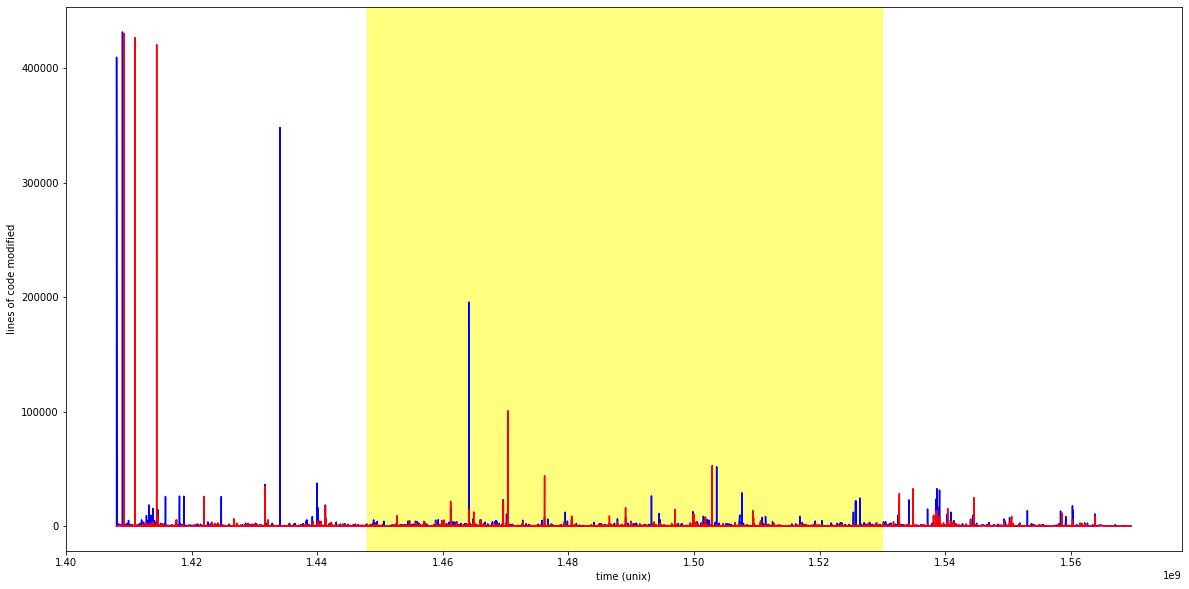

In [268]:
import matplotlib.pyplot as plt

all_dates     = []
all_insertions= []
all_deletions = []

all_commits = list(repo.iter_commits())
# all_commits.reverse()

print("local link: ", local_link)
print("VSS commit date:    ", worst_commit_date)
print("fixing commit date: ", fixing_commit_date)
print("total commits: ", len(all_commits))

count = 0

for commit in all_commits:
    # print(commit.stats.total['insertions'])
    # print(commit.stats.total['deletions'])
    # print(commit.stats.total['files'])
    
    all_insertions.append(commit.stats.total['insertions'])
    all_deletions.append(commit.stats.total['deletions'])
    all_dates.append(commit.committed_date)

#     all_filecount.append(commit.stats.total['files'])

#     if commit.committed_date == worst_commit_date:
#         print(ORANGE, commit.committed_date, ENDC)
#     if commit.committed_date > worst_commit_date and commit.committed_date < fixing_commit_date:    
#         print(BLUE, commit.committed_date, ENDC)
#     else:
    print(commit.committed_date)
        
    count +=1
#     if count == 100:
#         break

print(all_insertions)
        
# must call this before .plot()
plt.figure(figsize=(20,10))

# plot(x, y)
plt.plot(all_dates, all_insertions, color="blue")
plt.plot(all_dates, all_deletions , color="red")

plt.axvspan(worst_commit_date, fixing_commit_date, color='yellow', alpha=0.5)

plt.xlabel('time (unix)')
plt.ylabel('lines of code modified')
# plt.show()
plt.savefig(local_link + '.png')

# Loop through commits, plotting them by date
# highlight dates between worst and fix dates
